# 10. 확률적 경사하강법
Stochastic Gradient Descent

## 실습10.4 SGD 적용하기
### 1. 데이터 준비

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_california_housing

In [2]:
california = fetch_california_housing()

df = pd.DataFrame(california.data, columns=california.feature_names)
df['target'] = california.target
df.tail()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847
20639,2.3886,16.0,5.254717,1.162264,1387.0,2.616981,39.37,-121.24,0.894


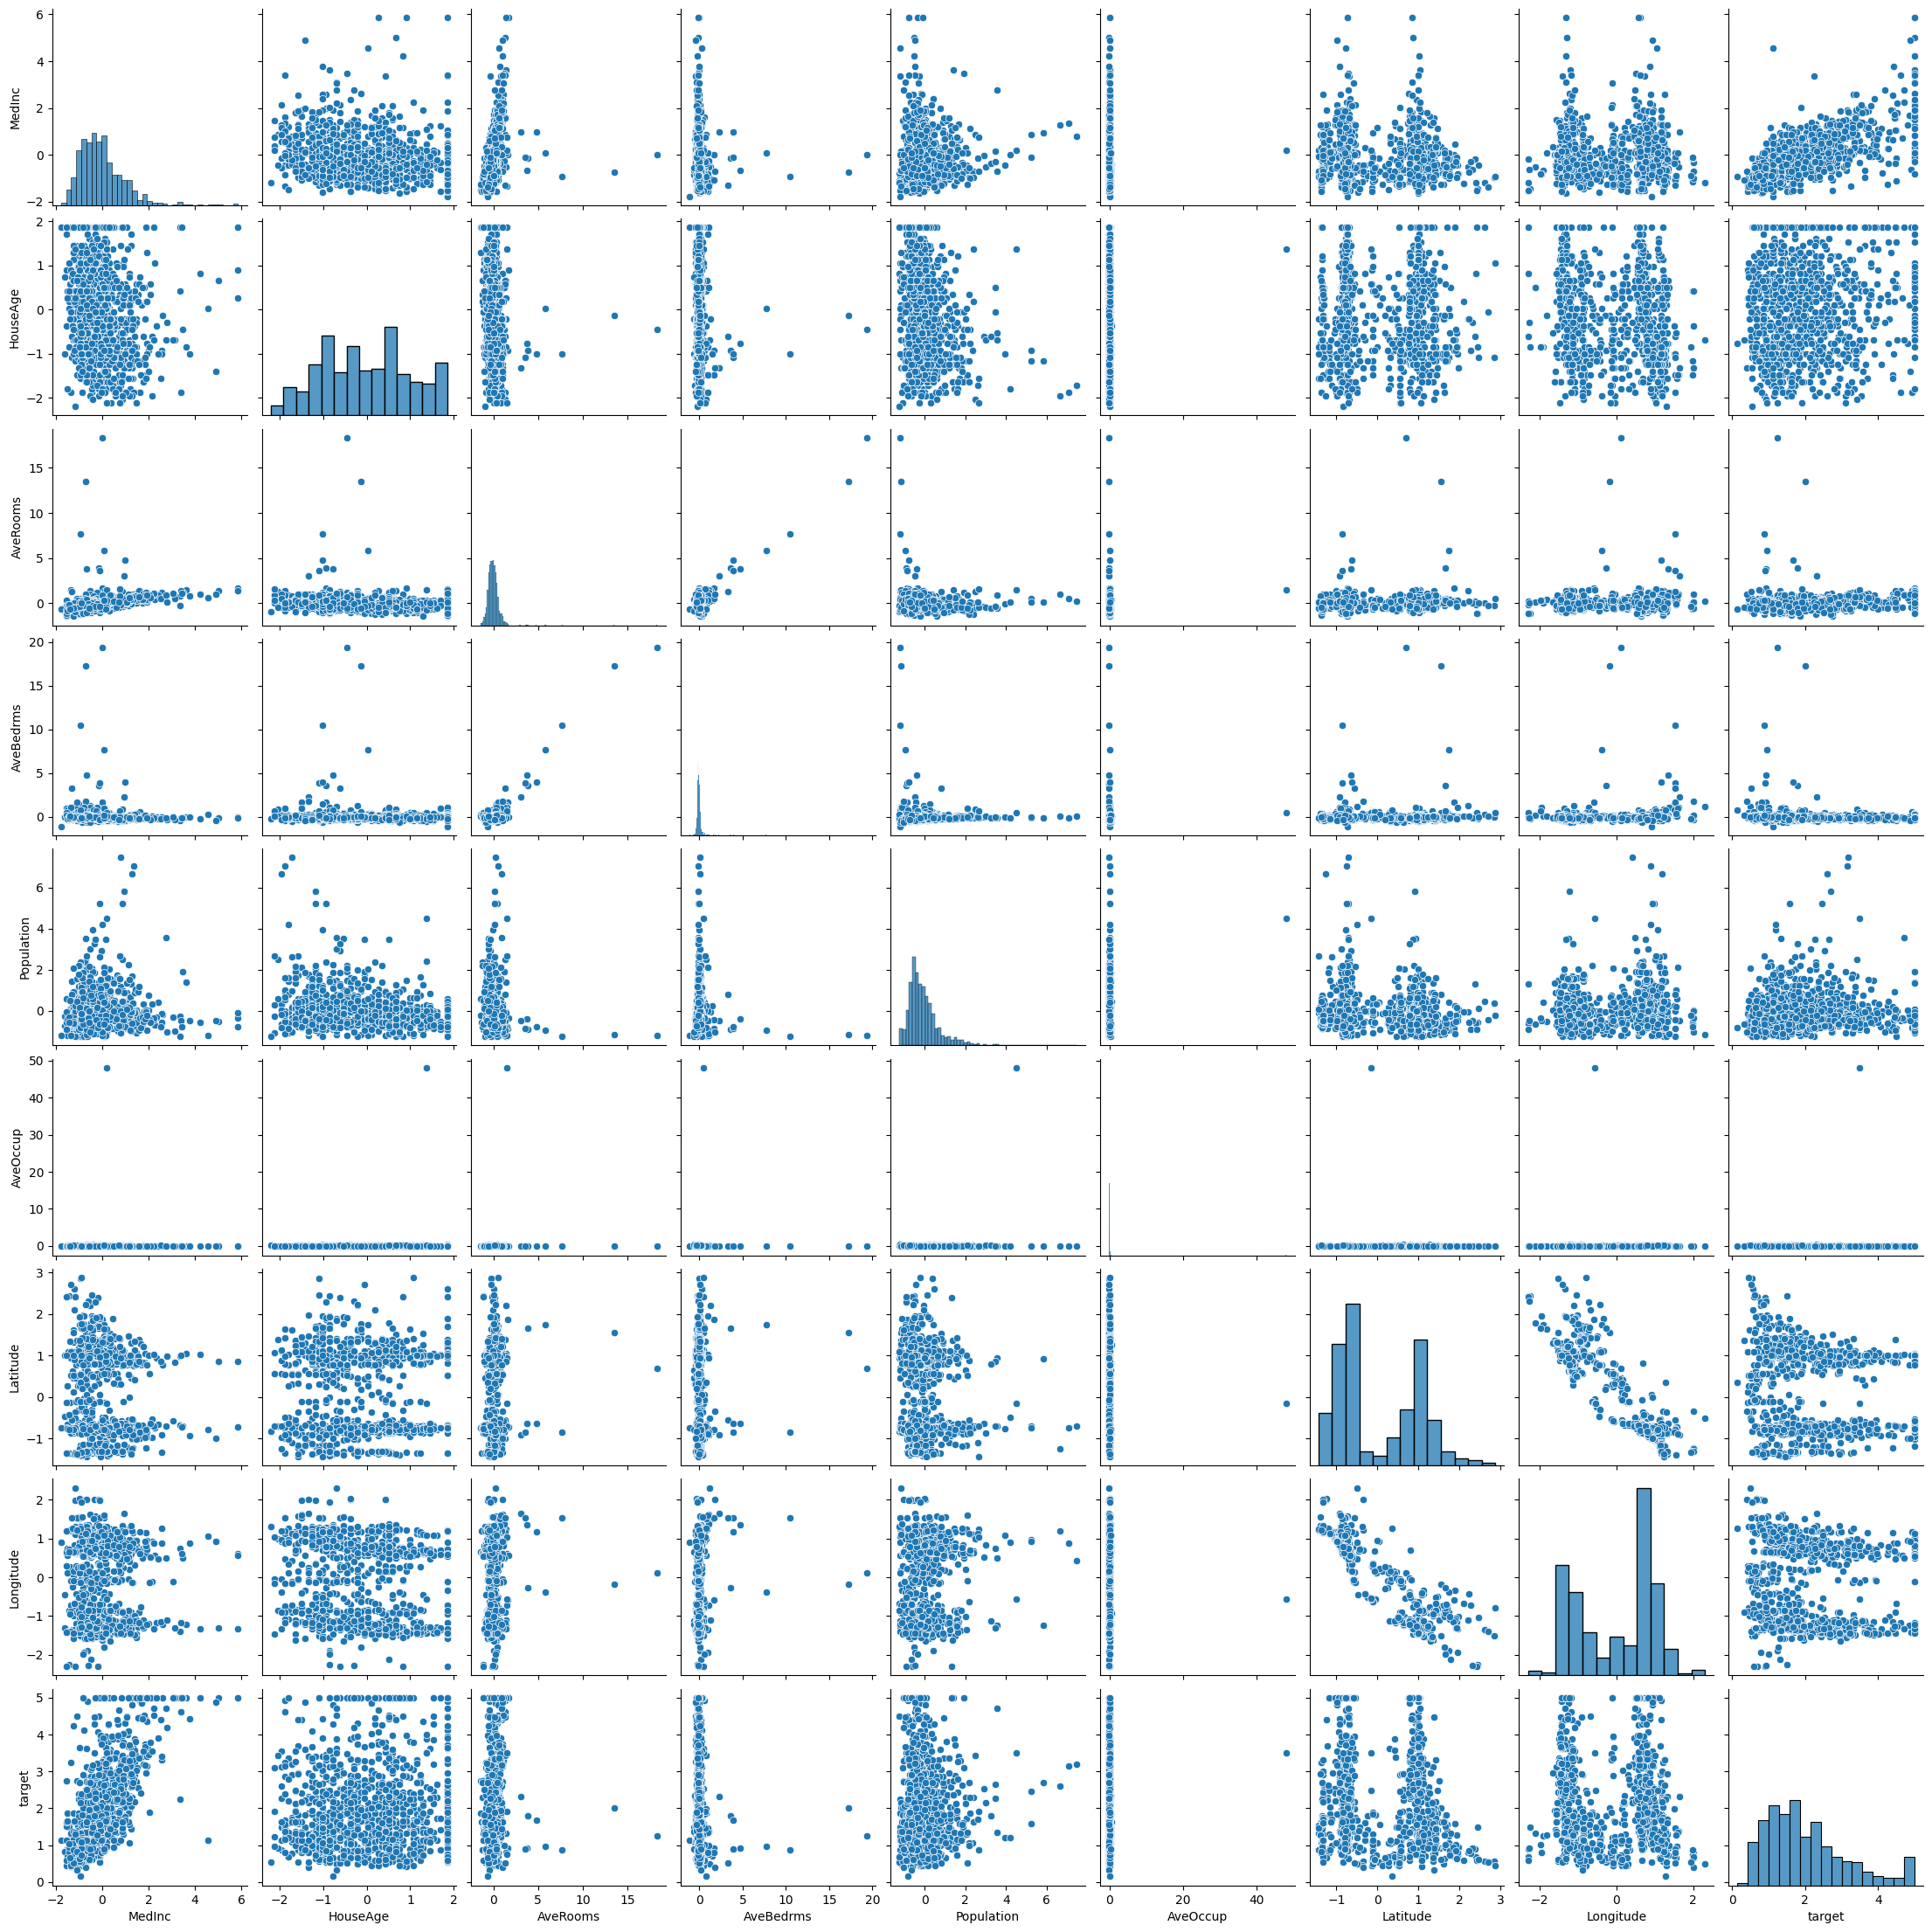

In [4]:
scaler = StandardScaler()
df.values[:, :-1] = scaler.fit_transform(df.values[:, :-1])
sns.pairplot(df.sample(1000))

### 2. 학습 코드 구현

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [6]:
data = torch.from_numpy(df.values).float()
data.shape

torch.Size([20640, 9])

In [7]:
x = data[:, :-1]
y = data[:, -1:]
print(x.shape, y.shape)

torch.Size([20640, 8]) torch.Size([20640, 1])


In [8]:
# 학습에 필요한 값 설정
n_epochs = 4000
lr = 1e-2
print_it = 200
batch_size = 256

In [9]:
# model
model = nn.Sequential(nn.Linear(x.size(-1), 6),
                      nn.LeakyReLU(),
                      nn.Linear(6, 5),
                      nn.LeakyReLU(),
                      nn.Linear(5, 4),
                      nn.LeakyReLU(),
                      nn.Linear(4, 3),
                      nn.LeakyReLU(),
                      nn.Linear(3, y.size(-1)),
                     )
model

Sequential(
  (0): Linear(in_features=8, out_features=6, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=6, out_features=5, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=5, out_features=4, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=4, out_features=3, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=3, out_features=1, bias=True)
)

In [10]:
optimizer = optim.SGD(model.parameters(), lr=lr)

In [16]:
for i in range(n_epochs):
    # epoch 마다 전체데이터를 랜덤하게 섞어서 미니배치 만들기
    # 일반적으로는 전체데이터 미니배치 한번만 돌리는데,
    # 이미지의 경우 픽셀값이 바뀌면 이미지증강의 역할이 되기 때문에 예시에서는 전체데이터를 epoch만큼 랜덤하게 섞어서 학습하는 방법을 사용함
    indices = torch.randperm(x.size(0))
    x_ = torch.index_select(x, dim=0, index=indices)
    y_ = torch.index_select(y, dim=0, index=indices)
    
    x_ = x_.split(batch_size, dim=0)
    y_ = y_.split(batch_size, dim=0)
    
    y_hat = []
    total_loss = 0
    
    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = F.mse_loss(y_hat_i, y_i)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # 미니배치의 loss를 더해두어야 전체 loss의 평균을 구할 수 있음
        total_loss += float(loss)
        
        y_hat += [y_hat_i]
        
    total_loss = total_loss / len(x_)
    if (i+1) % print_it == 0:
        print(f'Epoch {i+1}: loss={total_loss:.4e}')

Epoch 200: loss=3.4372e-01
Epoch 400: loss=3.1968e-01
Epoch 600: loss=3.0621e-01
Epoch 800: loss=2.9956e-01
Epoch 1000: loss=2.9579e-01
Epoch 1200: loss=2.9379e-01
Epoch 1400: loss=2.9464e-01
Epoch 1600: loss=2.9220e-01
Epoch 1800: loss=2.9275e-01
Epoch 2000: loss=2.9268e-01
Epoch 2200: loss=2.9049e-01
Epoch 2400: loss=2.9107e-01
Epoch 2600: loss=2.9190e-01
Epoch 2800: loss=2.9112e-01
Epoch 3000: loss=2.9065e-01
Epoch 3200: loss=2.9120e-01
Epoch 3400: loss=2.9060e-01
Epoch 3600: loss=2.9059e-01
Epoch 3800: loss=2.9038e-01
Epoch 4000: loss=2.9073e-01


In [17]:
y_hat = torch.cat(y_hat, dim=0)
y = torch.cat(y_, dim=0)

### 3. 결과 확인

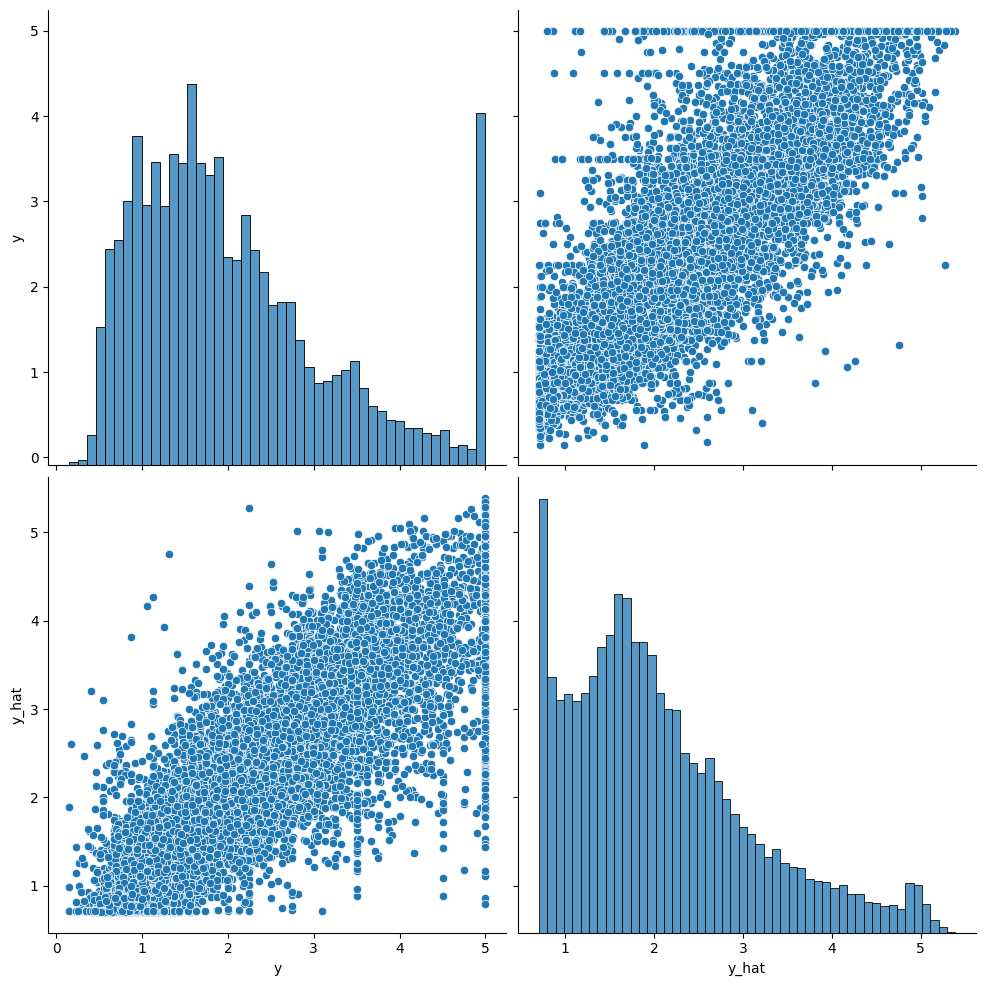

In [18]:
df = pd.DataFrame(torch.cat([y, y_hat], dim=1).detach_().numpy(), columns=['y', 'y_hat'])
sns.pairplot(df, height=5)